<a href="https://colab.research.google.com/github/Vivian0105/Bioinformatics/blob/main/scRNAseq_analysis_create_h5ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import warnings
warnings.simplefilter("ignore")
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import seaborn as sns
import os
import glob

In [8]:
samples=glob.glob('samples/*.h5')

In [9]:
samples[:3]

['samples/GSM4115880_SC68raw_feature_bc_matrix.h5',
 'samples/GSM4115869_SC2raw_feature_bc_matrix.h5',
 'samples/GSM4115886_SC125raw_feature_bc_matrix.h5']

In [10]:
meta=pd.read_csv('samples/SraRunTable.csv')
meta.head(2)

,Run,Assay Type,AssemblyName,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,chemistry,...,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue
0,SRR10254548,RNA-Seq,GCF_000001405.29,98,20294765414,PRJNA576702,SAMN13002514,8453401374,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:19:00Z,1,GSM4115868,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"
1,SRR10254549,RNA-Seq,GCF_000001405.29,98,26778655722,PRJNA576702,SAMN13002513,10356538606,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:18:00Z,1,GSM4115869,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"


In [11]:
# Read h5 files of each sample and concatenate the samples together
adatas = {}
for sample in samples:
    sample_name=sample[8:18]
    sample_adata = sc.read_10x_h5(sample)
    sample_adata.var_names_make_unique()
    sample_adata.obs['tissue']='skin'
    sample_adata.obs['sample_name']=sample_name
    sample_adata.obs['condition']=meta[meta['Sample Name']==sample_name]['condition'].item()
    adatas[sample_name] = sample_adata
adata = anndata.concat(adatas)
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16220160 × 33538
    obs: 'tissue', 'sample_name', 'condition'

In [12]:
adata.obs[['sample_name','condition']].drop_duplicates().condition.value_counts()

,count
condition,
SSC,12
CONTROL,10


In [13]:
adata.write('samples/GSE138669_RAW.h5ad')

In [9]:
# Now we have raw data of 22 patients with 16220160 cells and 33538 genes.

In [10]:
# Data Preprocessing

In [14]:
# adata=anndata.read_h5ad('samples/GSE138669_RAW.h5ad')

In [15]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [16]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [20]:
# filtered cells with less than 100 genes expressed.
# filtered genes that are detected in less than 3 cells.
print('After filtering, there are %i cells left with %i genes'%(adata.n_obs, adata.n_vars))

After filtering, there are 108726 cells left with 25208 genes


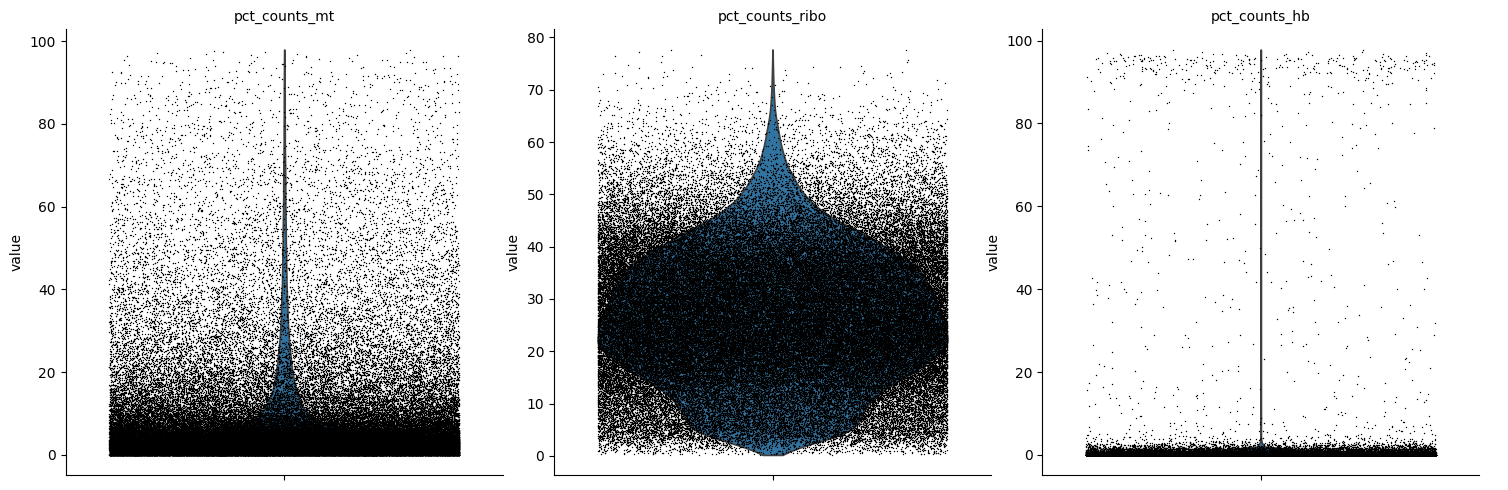

In [21]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

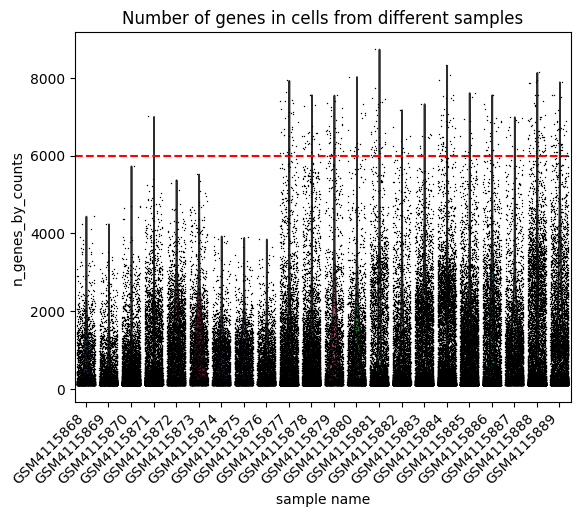

In [30]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ['n_genes_by_counts'],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Number of genes in cells from different samples")
ax.axhline(y=6000, color='r', linestyle='--')
plt.show()

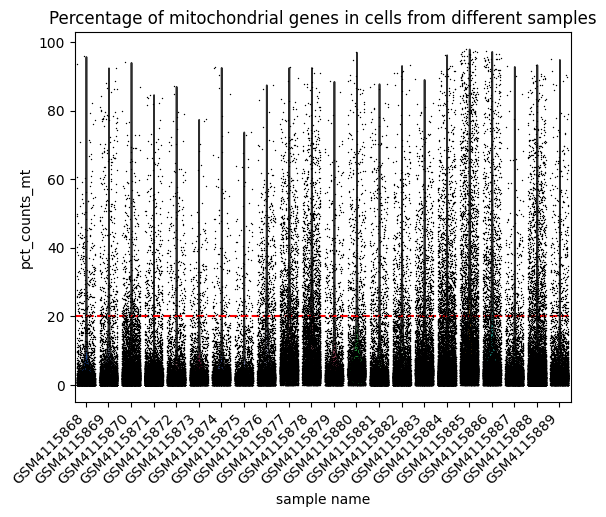

In [32]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Percentage of mitochondrial genes in cells from different samples")
ax.axhline(y=20, color='r', linestyle='--')
plt.show()

In [33]:
# Filter out cells with more than 6000 genes and cells with more than 20% mitochondrial genes

In [34]:
print('Before filtering, there are %i cells'%adata.n_obs)
adata=adata[adata.obs['n_genes_by_counts']<6000]
adata=adata[adata.obs['pct_counts_mt']<20]
print('After filtering, there are %i cells left.'%adata.n_obs)

Before filtering, there are 108726 cells
After filtering, there are 96808 cells left.


In [35]:
adata.write("samples/GSE138669_after_QC.h5ad")

In [37]:
# Normalization and Dimension Reduction